# LSTM predict Dow Jones Industrial Average for 5 business days after


In [1]:
import pandas_datareader.data as web

In [2]:
#load data
dataset=web.DataReader('^DJI',data_source='yahoo',start='2000-01-01')
print(dataset.head())
print('\n')
print(dataset.shape)

                    High           Low  ...     Volume     Adj Close
Date                                    ...                         
2000-01-03  11522.009766  11305.690430  ...  169750000  11357.509766
2000-01-04  11350.059570  10986.450195  ...  178420000  10997.929688
2000-01-05  11215.099609  10938.669922  ...  203190000  11122.650391
2000-01-06  11313.450195  11098.450195  ...  176550000  11253.259766
2000-01-07  11528.139648  11239.919922  ...  184900000  11522.559570

[5 rows x 6 columns]


(5251, 6)


In [3]:
dataset.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-06,28431.960938,28189.500000,28399.130859,28323.400391,326710000,28323.400391
2020-11-09,29933.830078,29130.660156,29467.900391,29157.970703,673310000,29157.970703
2020-11-10,29478.859375,29126.990234,29254.169922,29420.919922,526980000,29420.919922
2020-11-11,29593.109375,29281.220703,29524.349609,29397.630859,376700000,29397.630859
2020-11-12,29311.830078,28902.130859,29231.910156,29080.169922,369320000,29080.169922


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5251 entries, 2000-01-03 to 2020-11-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5251 non-null   float64
 1   Low        5251 non-null   float64
 2   Open       5251 non-null   float64
 3   Close      5251 non-null   float64
 4   Volume     5251 non-null   int64  
 5   Adj Close  5251 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 287.2 KB


Plot DJIE price histroy

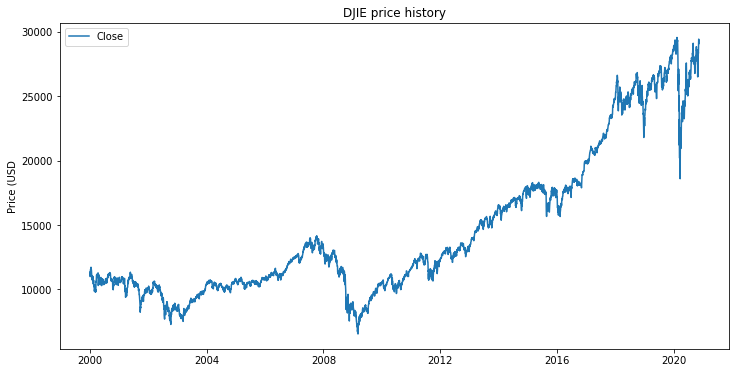

In [5]:
dataset.index.name='date'
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(dataset['Close'])
plt.title('DJIE price history')
plt.ylabel('Price (USD')
plt.legend(['Close'],loc='best')
plt.show()

In [6]:
data=dataset.copy()
#resetting index
df=data.reset_index()['Close']
df.shape


(5251,)

Data Normalization

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))
print(df1)

[[0.2091107 ]
 [0.19347975]
 [0.19890136]
 ...
 [0.99432716]
 [0.99331479]
 [0.97951476]]


Split training and testing data

In [8]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
train_data

array([[0.2091107 ],
       [0.19347975],
       [0.19890136],
       ...,
       [0.51872146],
       [0.50157424],
       [0.51199057]])

In [10]:
print(train_data.shape,test_data.shape)

(4200, 1) (1051, 1)


Data preparation

In [11]:
import numpy as np
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [12]:
#set timesteps=60 days
time_step=60
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [13]:
print(X_train)

[[0.2091107  0.19347975 0.19890136 ... 0.19846968 0.19469343 0.19079247]
 [0.19347975 0.19890136 0.20457895 ... 0.19469343 0.19079247 0.1943835 ]
 [0.19890136 0.20457895 0.21628542 ... 0.19079247 0.1943835  0.19271122]
 ...
 [0.48623069 0.4837242  0.48221795 ... 0.51608677 0.5192453  0.5212518 ]
 [0.4837242  0.48221795 0.4862576  ... 0.5192453  0.5212518  0.52073109]
 [0.48221795 0.4862576  0.48373897 ... 0.5212518  0.52073109 0.51872146]]


In [14]:
#reshape input to be 3D to feed into LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)


In [15]:
print(X_train.shape,y_train.shape)

(4139, 60, 1) (4139,)


Build LSTM architecture


In [16]:
from keras import models
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM, Dropout
from keras import optimizers
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


compile the model

In [17]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

num_epochs=50
batch_size=64

history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  epochs=num_epochs,
                  batch_size=batch_size)

Epoch 1/50
65/65 [==============================] - 2s 26ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 2/50
65/65 [==============================] - 1s 13ms/step - loss: 2.0961e-04 - val_loss: 0.0014
Epoch 3/50
65/65 [==============================] - 1s 12ms/step - loss: 2.1092e-04 - val_loss: 0.0016
Epoch 4/50
65/65 [==============================] - 1s 12ms/step - loss: 1.9404e-04 - val_loss: 0.0018
Epoch 5/50
65/65 [==============================] - 1s 12ms/step - loss: 1.8956e-04 - val_loss: 0.0017
Epoch 6/50
65/65 [==============================] - 1s 13ms/step - loss: 1.7594e-04 - val_loss: 0.0016
Epoch 7/50
65/65 [==============================] - 1s 14ms/step - loss: 1.8417e-04 - val_loss: 0.0012
Epoch 8/50
65/65 [==============================] - 1s 12ms/step - loss: 1.6399e-04 - val_loss: 0.0011
Epoch 9/50
65/65 [==============================] - 1s 12ms/step - loss: 1.5094e-04 - val_loss: 0.0011
Epoch 10/50
65/65 [==============================] - 1s 12ms/step - loss: 1.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


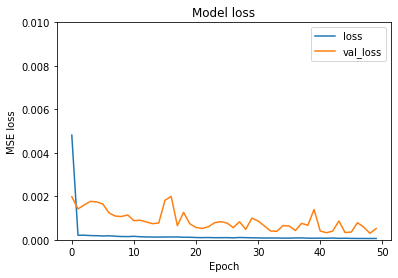

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.legend(['loss','val_loss'],loc='best')
axes = plt.axes()
axes.set_ylim([0, 0.01])
plt.show()

In [19]:
#prediction and check performance
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

In [20]:
#transform back to original form
train_pred=scaler.inverse_transform(train_pred)
test_pred=scaler.inverse_transform(test_pred)


In [21]:
#calculate MSE performance matrics
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train,train_pred)


154074106.8377077

In [22]:
#test data MSE
mean_squared_error(y_test,test_pred)

601634569.7247504

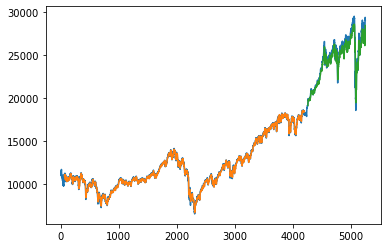

In [23]:
##plotting
look_back=60
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_pred)+look_back,:]=train_pred

testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df1)-1,:]=test_pred

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
len(test_data)

1051

In [42]:
x_input=test_data[len(test_data)-61:].reshape(1,-1)
x_input.shape

(1, 61)

In [43]:
temp_input=x_input
temp_input=temp_input[0].tolist()

# get prediction for 5 days after

In [44]:
from numpy import array

lst_output=[]
n_steps=60
i=0
day5_pred=[]
while(i<5):

  if(len(temp_input)>60):
    x_input=np.array(temp_input[1:])
    print('{} day input {}'.format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat=model.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    lst_output.extend(yhat.tolist())
    i=i+1

  else:
    x_input=x_input.reshape((1,n_steps,1))
    yhat=model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1

print(lst_output)

0 day input [0.92124586 0.92953122 0.94596857 0.94335944 0.94698833 0.95395873
 0.96098347 0.95125408 0.96062662 0.98039851 0.94528477 0.93835478
 0.91086349 0.92997204 0.91232797 0.91802517 0.93226983 0.93236849
 0.93396737 0.92829886 0.91766782 0.89551026 0.90161694 0.87879307
 0.88106693 0.89665185 0.91447889 0.90876691 0.92307024 0.92460043
 0.91877155 0.93902118 0.92268164 0.94575122 0.95105668 0.95807233
 0.96896675 0.96211114 0.95490335 0.95404261 0.95891609 0.94105468
 0.94598283 0.94172413 0.94836808 0.94714702 0.91888328 0.90922462
 0.86822196 0.87427126 0.86742431 0.88583173 0.90995665 0.92593756
 0.94952089 0.94661799 0.98289676 0.99432716 0.99331479 0.97951476]
0 day output [[0.95019186]]
1 day input [0.92953122 0.94596857 0.94335944 0.94698833 0.95395873 0.96098347
 0.95125408 0.96062662 0.98039851 0.94528477 0.93835478 0.91086349
 0.92997204 0.91232797 0.91802517 0.93226983 0.93236849 0.93396737
 0.92829886 0.91766782 0.89551026 0.90161694 0.87879307 0.88106693
 0.896651

In [31]:
#prediction result for 5 days after
pre_5days=[[0.8759302496910095], [0.8617682456970215], [0.835831880569458], [0.816233217716217], [0.8038196563720703]]
pre_5days=scaler.inverse_transform(pre_5days)
print(pre_5days)

[[26697.27346542]
 [26371.48548394]
 [25774.83574105]
 [25323.98084697]
 [25038.41468734]]


In [32]:
day_new=np.arange(1,61)
day_pred=np.arange(61,66)

In [33]:
len(df1)

5251

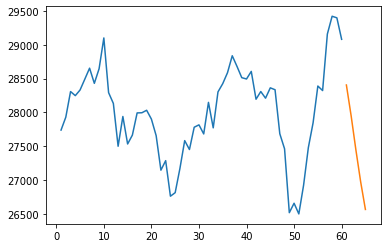

In [45]:
#plotting 5 days after prediction
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-60:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

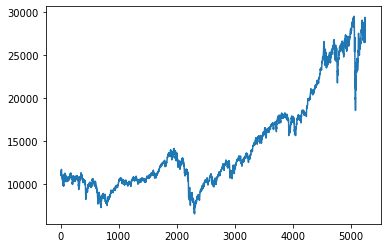

In [46]:
##plotting whole prediction results
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)